**A study on Regression applied to the Ames dataset by juliencs**　\
(https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset)

In [151]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

from sklearn.metrics import mean_squared_error, make_scorer

from scipy.stats import skew
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

In [47]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [48]:
train = pd.read_csv('train.csv')
train.shape

(1460, 81)

## ドメイン知識
参照元: (https://ww2.amstat.org/publications/jse/v19n3/decock.pdf)

Text(0.5, 1.0, 'Looking fof outliers')

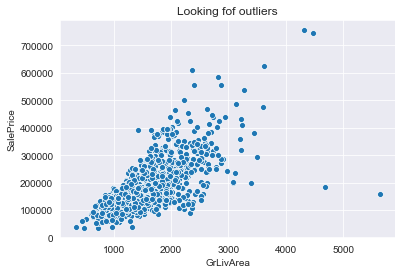

In [49]:
sns.scatterplot('GrLivArea', 'SalePrice', data=train)
plt.title('Looking fof outliers')

In [50]:
train = train[train['GrLivArea'] < 4000]

In [51]:
train['SalePrice'] = np.log1p(train['SalePrice'])
y = train['SalePrice']

## 欠損値の処理

In [52]:
#Alley: NA = 'no alley access'
train['Alley'].fillna('None', inplace=True)

# BedroomAbvGr : NA most likely means 0
train['BedroomAbvGr'].fillna(0, inplace=True)

# BsmtQual etc : NA for basement features is "no basement"
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train[col].fillna('No', inplace=True)
    
for col in ('BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF'):
    train[col].fillna(0, inplace=True)
    
# CentralAir : NA most likely means No
train['CentralAir'].fillna('N', inplace=True)

# Condition : NA most likely means Normal
for col in ('Condition1', 'Condition2'):
    train[col].fillna('Norm', inplace=True)
    
# EnclosedPorch : NA most likely means no enclosed porch
train['EnclosedPorch'].fillna(0, inplace=True)

# External stuff : NA most likely means average
for col in ('ExterCond', 'ExterQual'):
    train[col].fillna('TA', inplace=True)
    
# Fence : data description says NA means "no fence"
train['Fence'].fillna('No', inplace=True)

# FireplaceQu : data description says NA means "no fireplace"
train['FireplaceQu'].fillna('No', inplace=True)
train['Fireplaces'].fillna(0, inplace=True)

# Functional : data description says NA means typical
train['Functional'].fillna('Typ', inplace=True)

# GarageType etc : data description says NA for garage features is "no garage"
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train[col].fillna('No', inplace=True)
    
for col in ('GarageArea', 'GarageCars'):
    train[col].fillna(0, inplace=True)

# HalfBath : NA most likely means no half baths above grade
train['HalfBath'].fillna(0, inplace=True)

# HeatingQC : NA most likely means typical
train['HeatingQC'].fillna('TA', inplace=True)

# KitchenAbvGr : NA most likely means 0
train['KitchenAbvGr'].fillna(0, inplace=True)

# KitchenQual : NA most likely means typical
train['KitchenQual'].fillna('TA', inplace=True)

# LotFrontage : NA most likely means no lot frontage
train['LotFrontage'].fillna(0, inplace=True)

# LotShape : NA most likely means regular
train['LotShape'].fillna('Reg', inplace=True)

# MasVnrType : NA most likely means no veneer
train['MasVnrType'].fillna('None', inplace=True)
train['MasVnrArea'].fillna(0, inplace=True)

# MiscFeature : data description says NA means "no misc feature"
train['MiscFeature'].fillna('No', inplace=True)
train['MiscVal'].fillna(0, inplace=True)

# OpenPorchSF : NA most likely means no open porch
train['OpenPorchSF'].fillna(0, inplace=True)

# PavedDrive : NA most likely means not paved
train['PavedDrive'].fillna('N', inplace=True)

# PoolQC : data description says NA means "no pool"
train['PoolQC'].fillna('No', inplace=True)
train['PoolArea'].fillna(0, inplace=True)

# SaleCondition : NA most likely means normal sale
train['SaleCondition'].fillna('Normal', inplace=True)

# ScreenPorch : NA most likely means no screen porch
train['ScreenPorch'].fillna(0, inplace=True)

# TotRmsAbvGrd : NA most likely means 0
train['TotRmsAbvGrd'].fillna(0, inplace=True)

# Utilities : NA most likely means all public utilities
train['Utilities'].fillna('AllPub', inplace=True)

# WoodDeckSF : NA most likely means no wood deck
train['WoodDeckSF'].fillna(0, inplace=True)


In [53]:
# Some numerical features are actually really categories
train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                                     50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                                     80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                                     150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                         "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                              7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      }, inplace=True)

> **.replace()と.map()の違い**... \
全ての要素を置換する場合はmap()の方が高速。　\
全ての要素を置換しない場合はmap()を使うとNANを返す。repalce()は元の値のまま。

## Categorical変数をNumerical変数へ

In [54]:
# Encode some categorical features as ordered numbers when there is information in the order
train.replace({'Alley' : {'Grvl' : 1, 'Pave' : 2},
                        'BsmtCond' : {'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
                        'BsmtExposure' : {'No' : 0, 'Mn' : 1, 'Av': 2, 'Gd' : 3},
                        'BsmtFinType1' : {'No' : 0, 'Unf' : 1, 'LwQ': 2, 'Rec' : 3, 'BLQ' : 4, 'ALQ' : 5, 'GLQ' : 6},
                        'BsmtFinType2' : {'No' : 0, 'Unf' : 1, 'LwQ': 2, 'Rec' : 3, 'BLQ' : 4, 'ALQ' : 5, 'GLQ' : 6},
                        'BsmtQual' : {'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA': 3, 'Gd' : 4, 'Ex' : 5},
                        'ExterCond' : {'Po' : 1, 'Fa' : 2, 'TA': 3, 'Gd': 4, 'Ex' : 5},
                        'ExterQual' : {'Po' : 1, 'Fa' : 2, 'TA': 3, 'Gd': 4, 'Ex' : 5},
                        'FireplaceQu' : {'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
                        'Functional' : {'Sal' : 1, 'Sev' : 2, 'Maj2' : 3, 'Maj1' : 4, 'Mod': 5, 'Min2' : 6, 'Min1' : 7, 'Typ' : 8},
                        'GarageCond' : {'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
                        'GarageQual' : {'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
                        'HeatingQC' : {'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
                        'KitchenQual' : {'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
                        'LandSlope' : {'Sev' : 1, 'Mod' : 2, 'Gtl' : 3},
                        'LotShape' : {'IR3' : 1, 'IR2' : 2, 'IR1' : 3, 'Reg' : 4},
                        'PavedDrive' : {'N' : 0, 'P' : 1, 'Y' : 2},
                        'PoolQC' : {'No' : 0, 'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4},
                        'Street' : {'Grvl' : 1, 'Pave' : 2},
                        'Utilities' : {'ELO' : 1, 'NoSeWa' : 2, 'NoSewr' : 3, 'AllPub' : 4}
                        }, inplace=True)

 ## 変数の作成
- 既存変数を単純化
- 既存変数の掛け合わせ

- **既存変数の単純化**

In [62]:
train["SimplOverallQual"] = train['OverallQual'].replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                                                                 4 : 2, 5 : 2, 6 : 2, # average
                                                                                                 7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                                                                })

train["SimplOverallCond"] = train['OverallCond'].replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                                                                    4 : 2, 5 : 2, 6 : 2, # average
                                                                                                    7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                                                                    })

train["SimplPoolQC"] = train['PoolQC'].replace({1 : 1, 2 : 1, # average
                                                                                   3 : 2, 4 : 2 # good
                                                                                    })

train["SimplGarageCond"] = train['GarageCond'].replace({1 : 1, # bad
                                                                                                    2 : 1, 3 : 1, # average
                                                                                                    4 : 2, 5 : 2 # good
                                                                                                    })

train["SimplGarageQual"] = train['GarageQual'].replace({1 : 1, # bad
                                                                                                  2 : 1, 3 : 1, # average
                                                                                                  4 : 2, 5 : 2 # good
                                                                                                })

train["SimplFireplaceQu"] = train['FireplaceQu'].replace({1 : 1, # bad
                                                                                                   2 : 1, 3 : 1, # average
                                                                                                   4 : 2, 5 : 2 # good
                                                                                                })

train["SimplFunctional"] = train['Functional'].replace({1 : 1, 2 : 1, # bad
                                                                                              3 : 2, 4 : 2, # major
                                                                                              5 : 3, 6 : 3, 7 : 3, # minor
                                                                                              8 : 4 # typical
                                                                                              })

train["SimplKitchenQual"] = train['KitchenQual'].replace({1 : 1, # bad
                                                                                                    2 : 1, 3 : 1, # average
                                                                                                    4 : 2, 5 : 2 # good
                                                                                                    })

train["SimplHeatingQC"] = train['HeatingQC'].replace({1 : 1, # bad
                                                                                               2 : 1, 3 : 1, # average
                                                                                               4 : 2, 5 : 2 # good
                                                                                              })

train["SimplBsmtFinType1"] = train['BsmtFinType1'].replace({1 : 1, # unfinished
                                                                                                            2 : 1, 3 : 1, # rec room
                                                                                                            4 : 2, 5 : 2, 6 : 2 # living quarters
                                                                                                             })

train["SimplBsmtFinType2"] = train['BsmtFinType2'].replace({1 : 1, # unfinished
                                                                                                            2 : 1, 3 : 1, # rec room
                                                                                                            4 : 2, 5 : 2, 6 : 2 # living quarters
                                                                                                            })

train["SimplBsmtCond"] = train['BsmtCond'].replace({1 : 1, # bad
                                                                                              2 : 1, 3 : 1, # average
                                                                                              4 : 2, 5 : 2 # good
                                                                                              })

train["SimplBsmtQual"] = train['BsmtQual'].replace({1 : 1, # bad
                                                                                            2 : 1, 3 : 1, # average
                                                                                            4 : 2, 5 : 2 # good
                                                                                            })

train["SimplExterCond"] = train['ExterCond'].replace({1 : 1, # bad
                                                                                              2 : 1, 3 : 1, # average
                                                                                              4 : 2, 5 : 2 # good
                                                                                              })

train["SimplExterQual"] = train['ExterQual'].replace({1 : 1, # bad
                                                                                            2 : 1, 3 : 1, # average
                                                                                            4 : 2, 5 : 2 # good
                                                                                            })

- **既存変数の掛け合わせ**

In [63]:
# Overall quality of the house
train["OverallGrade"] = train["OverallQual"] * train["OverallCond"]

# Overall quality of the garage
train["GarageGrade"] = train["GarageQual"] * train["GarageCond"]

# Overall quality of the exterior
train["ExterGrade"] = train["ExterQual"] * train["ExterCond"]

# Overall kitchen score
train["KitchenScore"] = train["KitchenAbvGr"] * train["KitchenQual"]

# Overall fireplace score
train["FireplaceScore"] = train["Fireplaces"] * train["FireplaceQu"]

# Overall garage score
train["GarageScore"] = train["GarageArea"] * train["GarageQual"]

# Overall pool score
train["PoolScore"] = train["PoolArea"] * train["PoolQC"]

# Simplified overall quality of the house
train["SimplOverallGrade"] = train["SimplOverallQual"] * train["SimplOverallCond"]

# Simplified overall quality of the exterior
train["SimplExterGrade"] = train["SimplExterQual"] * train["SimplExterCond"]

# Simplified overall pool score
train["SimplPoolScore"] = train["PoolArea"] * train["SimplPoolQC"]

# Simplified overall garage score
train["SimplGarageScore"] = train["GarageArea"] * train["SimplGarageQual"]

# Simplified overall fireplace score
train["SimplFireplaceScore"] = train["Fireplaces"] * train["SimplFireplaceQu"]

# Simplified overall kitchen score
train["SimplKitchenScore"] = train["KitchenAbvGr"] * train["SimplKitchenQual"]

# Total number of bathrooms
train["TotalBath"] = train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"]) + train["FullBath"] + (0.5 * train["HalfBath"])

# Total SF for house (incl. basement)
train["AllSF"] = train["GrLivArea"] + train["TotalBsmtSF"]

# Total SF for 1st + 2nd floors
train["AllFlrsSF"] = train["1stFlrSF"] + train["2ndFlrSF"]

# Total SF for porch
train["AllPorchSF"] = train["OpenPorchSF"] + train["EnclosedPorch"] + train["3SsnPorch"] + train["ScreenPorch"]

# Has masonry veneer or not
train["HasMasVnr"] = train['MasVnrType'].replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, "Stone" : 1, "None" : 0})

# House completed before sale or not
train["BoughtOffPlan"] = train['SaleCondition'].replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})

- **相関性の高い10の二乗、三乗、ルート**

In [87]:
# Find most important features relative to target
corr = train.corr().sort_values(by='SalePrice', ascending=False)
corr.head(10).index

Index(['SalePrice', 'AllSF-Sq', 'OverallQual', 'AllSF', 'OverallQual-s2',
       'OverallQual-Sq', 'OverallQual-s3', 'AllSF-2', 'AllFlrsSF-Sq',
       'GrLivArea-Sq'],
      dtype='object')

In [88]:
train["OverallQual-s2"] = train["OverallQual"] ** 2
train["OverallQual-s3"] = train["OverallQual"] ** 3
train["OverallQual-Sq"] = np.sqrt(train["OverallQual"])

train["AllSF-2"] = train["AllSF"] ** 2
train["AllSF-3"] = train["AllSF"] ** 3
train["AllSF-Sq"] = np.sqrt(train["AllSF"])

train["AllFlrsSF-2"] = train["AllFlrsSF"] ** 2
train["AllFlrsSF-3"] = train["AllFlrsSF"] ** 3
train["AllFlrsSF-Sq"] = np.sqrt(train["AllFlrsSF"])

train["GrLivArea-2"] = train["GrLivArea"] ** 2
train["GrLivArea-3"] = train["GrLivArea"] ** 3
train["GrLivArea-Sq"] = np.sqrt(train["GrLivArea"])

train["SimplOverallQual-s2"] = train["SimplOverallQual"] ** 2
train["SimplOverallQual-s3"] = train["SimplOverallQual"] ** 3
train["SimplOverallQual-Sq"] = np.sqrt(train["SimplOverallQual"])

train["ExterQual-2"] = train["ExterQual"] ** 2
train["ExterQual-3"] = train["ExterQual"] ** 3
train["ExterQual-Sq"] = np.sqrt(train["ExterQual"])

train["GarageCars-2"] = train["GarageCars"] ** 2
train["GarageCars-3"] = train["GarageCars"] ** 3
train["GarageCars-Sq"] = np.sqrt(train["GarageCars"])

train["TotalBath-2"] = train["TotalBath"] ** 2
train["TotalBath-3"] = train["TotalBath"] ** 3
train["TotalBath-Sq"] = np.sqrt(train["TotalBath"])

train["KitchenQual-2"] = train["KitchenQual"] ** 2
train["KitchenQual-3"] = train["KitchenQual"] ** 3
train["KitchenQual-Sq"] = np.sqrt(train["KitchenQual"])

train["GarageScore-2"] = train["GarageScore"] ** 2
train["GarageScore-3"] = train["GarageScore"] ** 3
train["GarageScore-Sq"] = np.sqrt(train["GarageScore"])

## 欠損値を埋める

In [69]:
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns

numerical_features = numerical_features.drop("SalePrice")

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))

train_num = train[numerical_features]
train_cat = train[categorical_features]

Numerical features : 118
Categorical features : 26


In [114]:
train_num.isna().values.sum()

0

In [115]:
train_num = train_num.fillna(train_num.median())

## log置換
Numerical変数をlogに置換すると、外れ値の影響を抑えられる。 \
skewの絶対値が0.5以上だと歪んでいると言える。

In [122]:
skewness = train_num.apply(lambda x: x.skew())
skewness = skewness[abs(skewness) > 0.5]
skewness_features = skewness.index
train_num[skewness_features] = np.log1p(train_num[skewness_features])

## Create dummy features for categorical values

In [123]:
train_cat.isna().values.sum()

1

In [125]:
train_cat = pd.get_dummies(train_cat)

# モデリング
1. Linear Regression without regularization
2. Linear Regression with **Ridge** regularization (L2 penalty)
3. Linear Regression with **Lasso** regularization (L1 penalty)
4. Linear Regression with **ElasticNet** regularization (L1and L2 penalty)

In [207]:
train = pd.concat([train_num, train_cat], axis = 1)
print("New number of features : " + str(train.shape[1]))

X_train, X_val, y_train, y_val = train_test_split(train, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_val : " + str(X_val.shape))
print("y_train : " + str(y_train.shape))
print("y_val : " + str(y_val.shape))

New number of features : 320
X_train : (1019, 320)
X_val : (437, 320)
y_train : (1019,)
y_val : (437,)


## ? ※ Standardization cannot be done before the partitioning, as we don't want to fit the StandardScaler on some observations that will later be used in the test set. 

In [208]:
# Standardize numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])

> **make_scorer(score_func, greater_is_better=  )** ... \
scoreをつけるfunctionを決める。 \
値が大きほど良い場合(accuracy等)はgreater_is_better = True
値が小さいほど良い場合(MSE等)はgreater_is_better = False

In [209]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better=False)

def rmse_cv_train(model):
    rmse= np.sqrt(- cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_val(model):
    rmse= np.sqrt(- cross_val_score(model, X_val, y_val, scoring = scorer, cv = 10))
    return(rmse)

> **np.sqrt( - cross_val_score( ) )** ... \
make_scorer(greater_is_better = False)より、値がマイナスで返ってくるため、( - cross_val_score( ) )とする

## 1.LinearRegression without regularization

RMSE on Training set : 0.3887865731330381
RMSE on Validation set : 0.4199393577918153


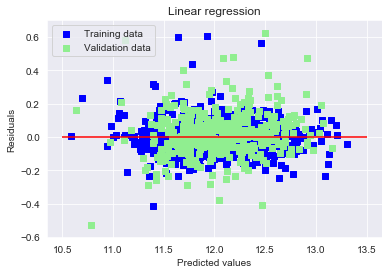

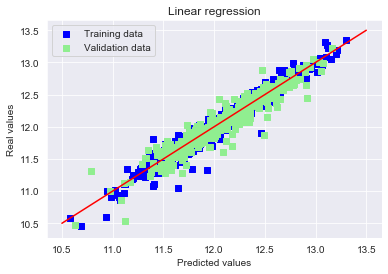

In [211]:
lr = LinearRegression()
lr.fit(X_train, y_train)

print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Validation set :", rmse_cv_val(lr).mean())
y_train_pred = lr.predict(X_train)
y_val_pred = lr.predict(X_val)

# Plot residuals
plt.figure()
plt.scatter(y_train_pred, (y_train_pred - y_train), c = "blue", marker = "s", label = "Training data")
plt.scatter(y_val_pred, (y_val_pred - y_val), c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")

# Plot predictions
plt.figure()
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_val_pred, y_val, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")

## 2. Linear Regression with Ridge regularization (L2 penalty)
Regularization is a very useful method to handle  collinearity(共線性), filter out noise from data, and eventually prevent overfitting.

Best alpha : 30.0
Try again for more precision with alphas centered around 30.0
Best alpha : 24.0
Ridge RMSE on Training set : 0.1156810222610902
Ridge RMSE on Validation set : 0.11656790696349244
Ridge picked 317 features and eliminated the other 3 features


Text(0.5, 1.0, 'Coefficients in the Ridge Model')

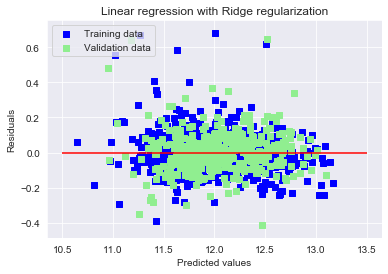

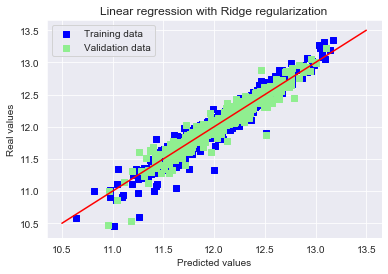

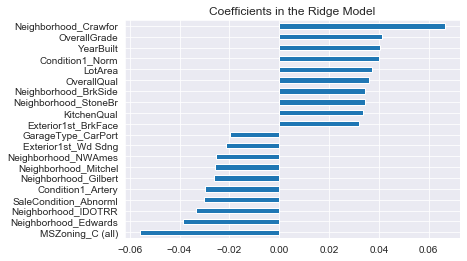

In [212]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)

alpha = ridge.alpha_
print("Best alpha :", alpha)
print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                                              alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                                              alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                            cv = 10)
ridge.fit(X_train, y_train)

alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Validation set :", rmse_cv_val(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_val_rdg = ridge.predict(X_val)

# Plot residuals
plt.figure()
plt.scatter(y_train_rdg, (y_train_rdg - y_train), c = "blue", marker = "s", label = "Training data")
plt.scatter(y_val_rdg, (y_val_rdg - y_val), c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")

# Plot predictions
plt.figure()
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_val_rdg, y_val, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")


# Plot important coefficients
coefs = pd.Series(ridge.coef_, index=X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10), coefs.sort_values().tail(10)])

plt.figure()
imp_coefs.plot(kind="barh")
plt.title("Coefficients in the Ridge Model")

RMSEは改善された。\
trainingとvalの誤差が小さくなったことよりoverfittingを取り除いたことがわかる。\
317の変数を用いた。

## 3. Linear Regression with Lasso regularization (L1 penalty)
 In contrast to L2 regularization, L1 regularization yields sparse(希薄) feature vectors : most feature weights will be zero. \
 Sparsity can be useful in practice if we have a high dimensional dataset with many features that are irrelevant(無関係). \
We can suspect that it should be more efficient than Ridge here.

Best alpha : 0.0006
Try again for more precision with alphas centered around 0.0006
Best alpha : 0.0006
Lasso RMSE on Training set : 0.1144004322103778
Lasso RMSE on Validation set : 0.11608019082568459
Lasso picked 110 features and eliminated the other 210 features


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

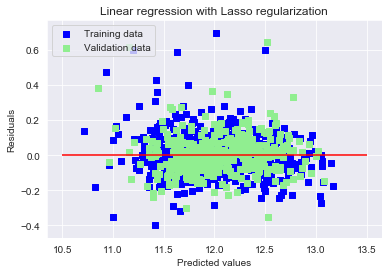

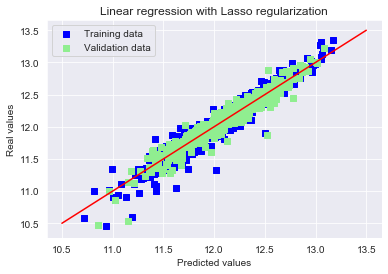

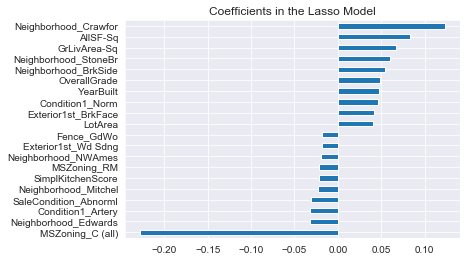

In [213]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1], 
                             max_iter = 50000, 
                             cv = 10)
lasso.fit(X_train, y_train)

alpha = lasso.alpha_
print("Best alpha :", alpha)
print("Try again for more precision with alphas centered around " + str(alpha))

lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                                               alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                                               alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                            max_iter = 50000,
                            cv = 10)
lasso.fit(X_train, y_train)

alpha = lasso.alpha_
print("Best alpha :", alpha)
print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Validation set :", rmse_cv_val(lasso).mean())
y_train_las = lasso.predict(X_train)
y_val_las = lasso.predict(X_val)

# Plot residuals
plt.figure()
plt.scatter(y_train_las, (y_train_las - y_train), c = "blue", marker = "s", label = "Training data")
plt.scatter(y_val_las, (y_val_las - y_val), c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")

# Plot predictions
plt.figure()
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_val_las, y_val, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " + str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10), coefs.sort_values().tail(10)])

plt.figure()
imp_coefs.plot(kind="barh")
plt.title("Coefficients in the Lasso Model")

110の変数しか用いていない(1/3)

## 4. Linear Regression with ElasticNet regularization (L1 and L2 penalty)
ElasticNet is a compromise between Ridge and Lasso regression. \
It has a L1 penalty to generate sparsity and a L2 penalty to overcome some of the limitations of Lasso, such as the number of variables 

Best l1_ratio : 1.0
Best alpha : 0.0006
Try again for more precision with l1_ratio centered around 1.0
Best l1_ratio : 1.0
Best alpha : 0.0006
Now try again for more precision on alpha, with l1_ratio fixed at 1.0 and alpha centered around 0.0006
Best l1_ratio : 1.0
Best alpha : 0.0006
ElasticNet RMSE on Training set : 0.1144004322103778
ElasticNet RMSE on Test set : 0.11608019082568459
ElasticNet picked 110 features and eliminated the other 210 features


Text(0.5, 1.0, 'Coefficients in the ElasticNet Model')

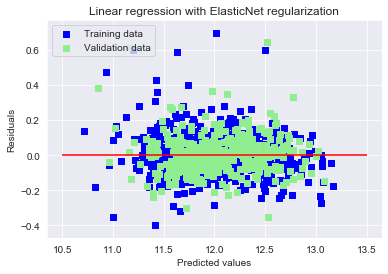

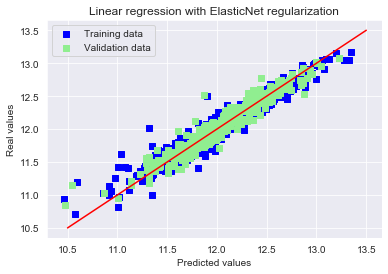

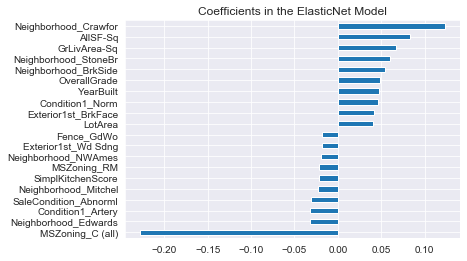

In [214]:
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                                              alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                                              max_iter = 50000, 
                                              cv = 10)
elasticNet.fit(X_train, y_train)

alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )
print("Try again for more precision with l1_ratio centered around " + str(ratio))

elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                                              alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                                              max_iter = 50000,
                                              cv = 10)
elasticNet.fit(X_train, y_train)

if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + " and alpha centered around " + str(alpha))

elasticNet = ElasticNetCV(l1_ratio = ratio,
                                              alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                                               alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                                               alpha * 1.35, alpha * 1.4], 
                                              max_iter = 50000, 
                                              cv = 10)
elasticNet.fit(X_train, y_train)

if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_val(elasticNet).mean())
y_train_ela = elasticNet.predict(X_train)
y_val_ela = elasticNet.predict(X_val)

# Plot residuals
plt.figure()
plt.scatter(y_train_ela, (y_train_ela - y_train), c = "blue", marker = "s", label = "Training data")
plt.scatter(y_val_ela, (y_val_ela - y_val), c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")

# Plot predictions
plt.figure()
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_val, y_val_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10), coefs.sort_values().tail(10)])

plt.figure()
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")